# Анализ гипотез для увеличения выручки интернет-магазина

**Цель проекта:** предоставить данные, которые могут помочь увеличению выручки крупного интернет-магазина.

**Исходные данные:** имеем подготовленный вместе с отделом маркетинга список гипотез.

**Задачи:**
1. приоритизация гипотез;
2. запуск A/B-теста и анализ результатов.


## Загрузка и подготовка данных

In [20]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px
import scipy.stats as st
import datetime as dt
import seaborn as sns
import pandas as pd 
import numpy as np
import warnings
import math

warnings.filterwarnings('ignore')

### Загрузка данных

Положим данные о гипотезах, заказах и пользователей в переменные:

In [21]:
hypothesis = pd.read_csv('hypothesis.csv') 
orders = pd.read_csv('orders.csv') 
visitors = pd.read_csv('visitors.csv') 

Рассмотрим данные внимательнее:

In [22]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [23]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


На всякий случай проверим, сколько уникальных занчений в столбце group:

In [24]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [25]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Аналогично таблице с заказами проверим, сколько уникальных занчений в столбце group:

In [26]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

### Подготовка данных

Подготовим данные. Убедимся, что тип данных во всех колонках соответствует сохранённым в них значениям.

In [27]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [28]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [29]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Приведем столбцы с датами к соотв. типу:

In [30]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Приведем остальные столбцы к нужному типу:

In [31]:
hypothesis['Reach'] = np.uint16(hypothesis['Reach'])
hypothesis['Impact'] = np.uint16(hypothesis['Impact']) 
hypothesis['Confidence'] = np.uint16(hypothesis['Confidence']) 
hypothesis['Efforts'] = np.uint16(hypothesis['Efforts'])
#orders['group'] = orders['group'].astype('category')
#visitors['group'] = visitors['group'].astype('category')

Проверим временной интервал по датам в таблицах с заказами и посетителями:

In [32]:
orders['date'].describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [33]:
visitors['date'].describe()

count                      62
unique                     31
top       2019-08-27 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Итак, период А/В теста: с 1 по 30 августа 2019 года.

Убедимся, что пользователи в группах разные, т. е. не может быть в двух группах одинаковых пользователей.

Проверим, скольк уникальных пользователей в каждой из групп:

In [34]:
usersByGroup = (
    orders.drop(['transactionId', 'revenue', 'date'], axis=1) 
    .groupby('group', as_index=False) 
    .agg({'visitorId': pd.Series.nunique})
)
usersByGroup.columns = ['group','visitors']
usersByGroup

,group,visitors
0,A,503
1,B,586


Выделим отдельно всех дублиурующихся пользователей:

In [35]:
visitors_duplicates = orders[orders.duplicated(subset=['visitorId'], keep=False)].sort_values(by='visitorId')
visitors_duplicates.head(10)

,transactionId,visitorId,date,revenue,group
71,3679129301,8300375,2019-08-01,10510,B
703,4293855558,8300375,2019-08-07,1790,A
1102,1941707234,199603092,2019-08-12,6438,A
823,2971973105,199603092,2019-08-27,2790,A
134,62794304,199603092,2019-08-22,6976,A
26,2223239646,199603092,2019-08-15,3488,A
246,437656952,199603092,2019-08-02,3488,B
1013,83566152,232979603,2019-08-31,60,A
1009,2670069237,232979603,2019-08-31,2640,B
1097,3357467820,237748145,2019-08-12,340,A


Составим фильтр пользователей, которые входят в обе группы:

In [36]:
vd = visitors_duplicates.groupby('visitorId', as_index=False).agg({'group': pd.Series.nunique})
vd

,visitorId,group
0,8300375,2
1,199603092,2
2,232979603,2
3,237748145,2
4,249864742,1
...,...,...
89,4120364173,2
90,4134830387,1
91,4186807279,2
92,4256040402,2


Проверим полученный фильтр:

In [37]:
visitors_duplicates[visitors_duplicates['visitorId'] == 8300375]

,transactionId,visitorId,date,revenue,group
71,3679129301,8300375,2019-08-01,10510,B
703,4293855558,8300375,2019-08-07,1790,A


In [38]:
escape_visitors = vd[vd['group'] == 2]['visitorId']
print('Ко-во пользователей, которые дублируются в обеих группах:', escape_visitors.count())

Ко-во пользователей, которые дублируются в обеих группах: 58


Теперь исключим записи с дублирующимися пользователями из группы B, т. к. в этой группе пользователей и так больше, чем в другой группе:

In [39]:
orders = orders[~((orders['visitorId'].isin(escape_visitors)) & (orders['group'] == 'B'))]
orders['visitorId'].count()

1105

Таким образом, исключили 92 записи дублирующихся пользователей из группы B.

### Описание данных

Имеем 3 таблицы с данными:
1. гипотезы по увеличению выручки, 9 шт. с описанием и соотв. параметрами - Reach (охват пользователей по 10-балльной шкале), Impact (влияние на пользователей по 10-балльной шкале), Confidence (уверенность в гипотезе по 10-балльной шкале), Efforts (затраты ресурсов на проверку гипотезы по 10-балльной шкале)
2. таблица с заказами
3. таблица с посеетителями интернет-магазина

Период А/В теста: с 1 по 30 августа 2019 года.

Убраны записи по дублирующимся пользвателям: в группе A 503 пользователя, в группе B - 528 уникальных пользователей.

## Приоритизация гипотез

### Приоритизация гипотез с помщью фреймворка ICE

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [40]:
#pd.options.display.max_colwidth = 110

hypothesis['ICE'] = (
    hypothesis['Impact'] * hypothesis['Confidence']/hypothesis['Efforts']
).round(1)
hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.2
0,"Добавить два новых канала привлечения трафика,...",13.3
7,Добавить форму подписки на все основные страни...,11.2
6,Показать на главной странице баннеры с актуаль...,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,7.0
1,"Запустить собственную службу доставки, что сок...",2.0
5,"Добавить страницу отзывов клиентов о магазине,...",1.3
3,"Изменить структура категорий, что увеличит кон...",1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",1.0


Первые 3 места при приоритизации с помощью ICE занимают следующие гипотезы в порядке убывания:
1. "день рождения" - запустить акцию, дающую скидку на товар в день рождения
2. "два новых канала" - добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
3. "база клиентов" - добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

### Приоритизация гипотез с помщью фреймворка RICE

Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [41]:
hypothesis['RICE'] = (
    hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']/hypothesis['Efforts']
)
hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


In [42]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

hypothesis[['Hypothesis', 'ICE', 'RICE']].style.apply(highlight_max, subset=['ICE', 'RICE'])

,Hypothesis,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.300000,40.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.100000,9.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.300000,4.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000


Первые 3 места при приоритизации с помощью RICE занимают следующие гипотезы в порядке убывания:
1. "база клиентов" - добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок 
2. "блоки рекомендаций" - добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа 
3. "два новых канала" - добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей 
4. "актуальные акции" - показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию 

### Сравнение приоритизаций ICE и RICE

Укажем, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясним, почему так произошло.

* гипотеза "база клиентов" была на 3-м месте при приориитизации  ICE, но при приоритизации RICE с большим отрывом вырывается вперед. Так получилось из-за того, что имеенно данная гипотеза имеет высший балл по охвату (10)
* "блоки рекомендаций" - не было в тройке при приоритизации ICE, там эта гипотеза была на пятом месте; при RICE - на втором месте. Здесь это благодаря опять же охвату (8), а также благодаря достаточно высокой уверенности в гипотезе (7)
* "два новых канала" встречается в обеих приоритизациях, но в ICE она на втором месте, а в RICE - на третьем (небольшое значение охвата (3) при высоких остальных параметрах, участвующих в ICE)
* при приоритизации RICE третье место делят две гиптезы - "два новых канала" и "актуальные акции"

## Анализ A/B-теста

Мы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.
Проанализируем A/B-тест.

Прежде чем строить графики, соберем кумулятивные данные. 

In [43]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(
        orders['date'] <= x['date'],
        orders['group'] == x['group']
    )].agg({
        'date' : 'max', 
        'group' : 'max', 
        'transactionId' : pd.Series.nunique, 
        'visitorId' : pd.Series.nunique, 
        'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], 
            visitors['group'] == x['group']
        )].agg({
        'date' : 'max',
        'group' : 'max',
        'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulativeData.columns = [
    'date', 
    'group', 
    'orders', 
    'buyers', 
    'revenue', 
    'visitors'
]

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,68,62,354874,1845


### График кумулятивной выручки по группам

Построим график кумулятивной выручки по группам. 

In [44]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

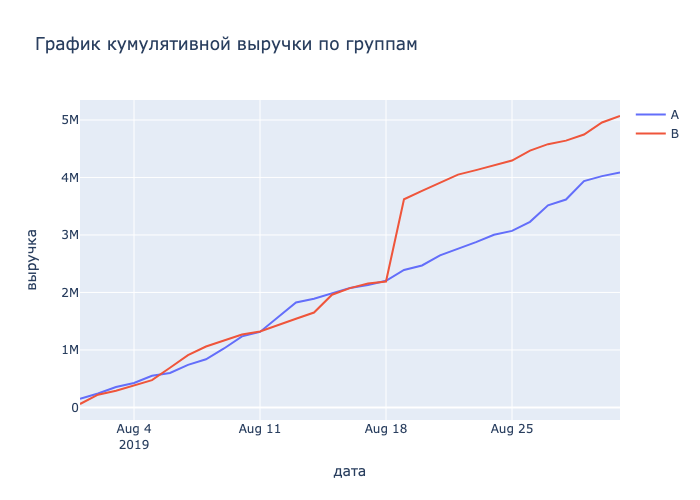

In [72]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=cumulativeRevenueA['date'], y=cumulativeRevenueA['revenue'], name='A'))
fig.add_trace(go.Scatter(x=cumulativeRevenueB['date'], y=cumulativeRevenueB['revenue'], name='B'))
fig.update_layout(title="График кумулятивной выручки по группам",
                  xaxis_title="дата",
                  yaxis_title="выручка")
fig.show(renderer="png")

Выручка увеличивается в течение всего теста.

#### Выводы и предположения

График группы A растет равномерно, тогда как график группы B в одной точке начинает резко расти - либо это всплески числа заказов, либо появление очень дорогих заказов в выборке.

### График кумулятивного среднего чека по группам

Построим график кумулятивного среднего чека по группам.

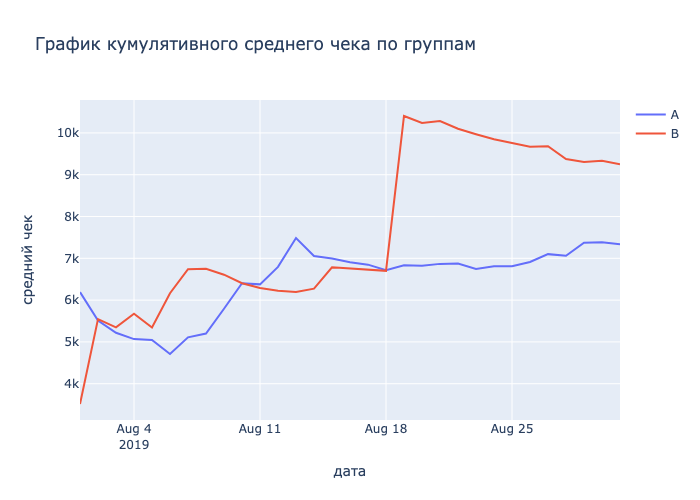

In [73]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=cumulativeRevenueA['date'], y=cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], name='A'))
fig.add_trace(go.Scatter(x=cumulativeRevenueB['date'], y=cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], name='B'))
fig.update_layout(title="График кумулятивного среднего чека по группам",
                  xaxis_title="дата",
                  yaxis_title="средний чек")
fig.show(renderer="png")

В группе B снова резкий скачок с 18 на 19 августа. И с этого момента средний чек разительно отличается в группах. 

#### Выводы и предположения

Похоже, что в группу B с 18 августа (воскресенье) пришли очень активные пользователи, которые сделали много заказов, что повлияло на средний чек.

### График относительного изменения кумулятивного среднего чека группы B к группе A

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

In [48]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)

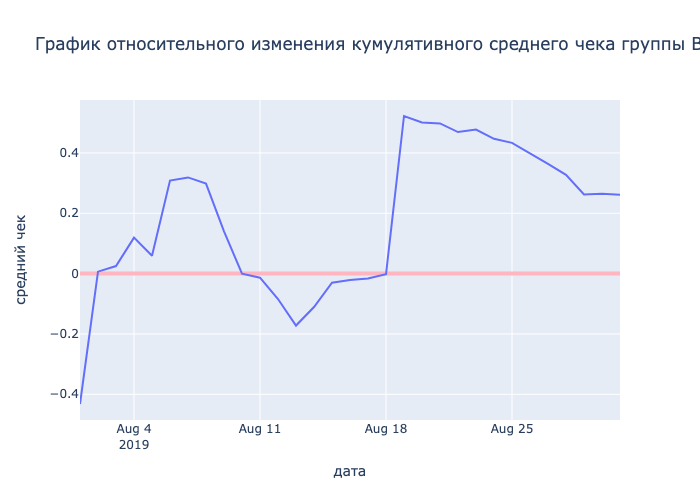

In [74]:
# cтроим отношение средних чеков
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=mergedCumulativeRevenue['date'], 
    y=(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, 
    name='A'))

fig.update_yaxes(
    zeroline=True, 
    zerolinewidth=4, 
    zerolinecolor='LightPink')

fig.update_layout(
    title="График относительного изменения кумулятивного среднего чека группы B к группе A",
    xaxis_title="дата",
    yaxis_title="средний чек")

fig.show(renderer="png")

В нескольких точках график скачет, например, с 8 по 19 августа. 

#### Выводы и предположения

Похоже, что нам предстоит обнаружить крупные заказы и выбросы.

### График кумулятивной конверсии по группам

Построим график кумулятивной конверсии по группам.

In [50]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

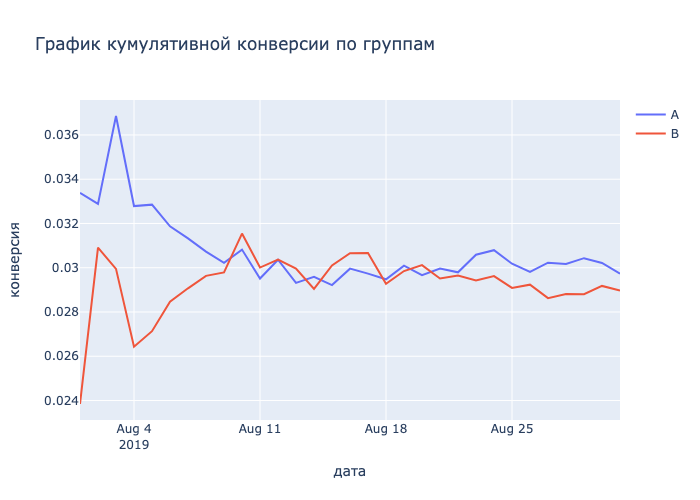

In [75]:
# строим графики
fig = go.Figure()
fig.add_trace(go.Scatter(x=cumulativeDataA['date'], y=cumulativeDataA['conversion'], name='A'))
fig.add_trace(go.Scatter(x=cumulativeDataB['date'], y=cumulativeDataB['conversion'], name='B'))
fig.update_layout(title="График кумулятивной конверсии по группам",
                  xaxis_title="дата",
                  yaxis_title="конверсия")

fig.show(renderer="png")

Вначале группы колебались, но с 9 августа конверсии начали выравниваться, а после 22 августа конверсия группы A стала чуть вышее конверсии группы B.

#### Выводы и предположения

Конверсии обеих групп начали выравниваться, начиная с 10 августа.

### График относительного изменения кумулятивной конверсии группы B к группе A

Построим график относительного изменения кумулятивной конверсии группы B к группе A.

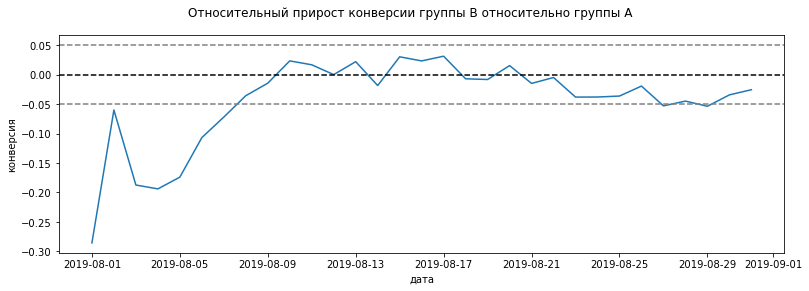

In [77]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(13, 4))

plt.plot(
    mergedCumulativeConversions['date'], 
    mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.suptitle('Относительный прирост конверсии группы B относительно группы A')
plt.ylabel('конверсия')
plt.xlabel('дата')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.05, color='grey', linestyle='--')
plt.axhline(y=-0.05, color='grey', linestyle='--')

plt.show()

По графику видим, что группа B лидирует по конверсии, выравниваясь дальше с приростом около 5%.

#### Выводы и предположения

Наблюдаем прирост конверсии группы B в 5% относительно группы A с 10 августа, но затем в районе 22 августа конверсия группы B пошла на спад относительно группы B.

### График количества заказов по пользователям


Найдем сначала число заказов по пользователям:

In [56]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1) 
    .groupby('visitorId', as_index=False) 
    .agg({'transactionId' : pd.Series.nunique})
)
ordersByUsers.columns = ['visitorId','orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

       visitorId  orders
1023  4256040402       7
487   2038680547       5
591   2458001652       5
44     199603092       4
569   2378935119       4
55     237748145       4
504   2108163459       3
667   2742574263       3
959   3967698036       3
726   2988190573       3


Построим точечный график количества заказов по пользователям. 

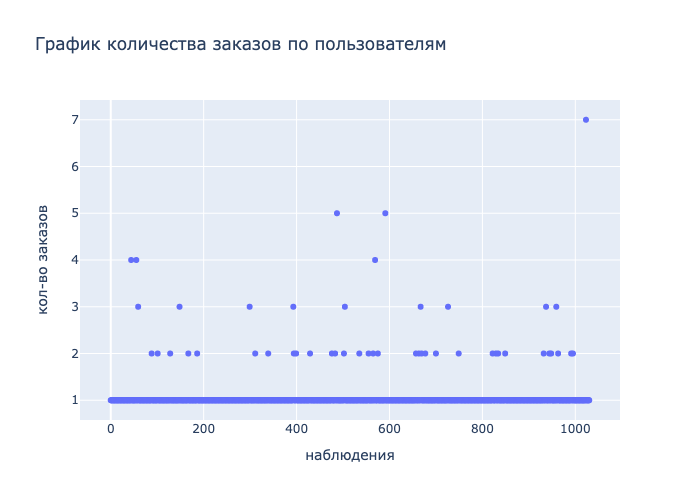

In [78]:
x_values = pd.Series(range(0, len(ordersByUsers)))

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x_values,
    y=ordersByUsers['orders'],
    mode='markers'))

fig.update_layout(title="График количества заказов по пользователям",
                  xaxis_title="наблюдения",
                  yaxis_title="кол-во заказов")
fig.show(renderer="png")

Больше всего пользователей, заказавших один раз. Заказавших больше двух раз уже намного меньше. А вот больше пяти - всего 4 пользвателя.

#### Выводы и предположения

Пользователей, которые заказали больше трех раз, достаточно мало - это могут быть выбросы.

### 95-й и 99-й перцентили количества заказов на пользователя

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [58]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 3.]


Не более 5% пользователей сделали больше одного заказа. И не более 1% - больше 3-х заказов.

#### Выводы и предположения

Выберем границу для определения аномальных пользователей. Ориентируясь на график и по вычисленным перцентилям выберем такую границу: больше трех заказов.

### График стоимостей заказов

Построим точечный график стоимостей заказов. 

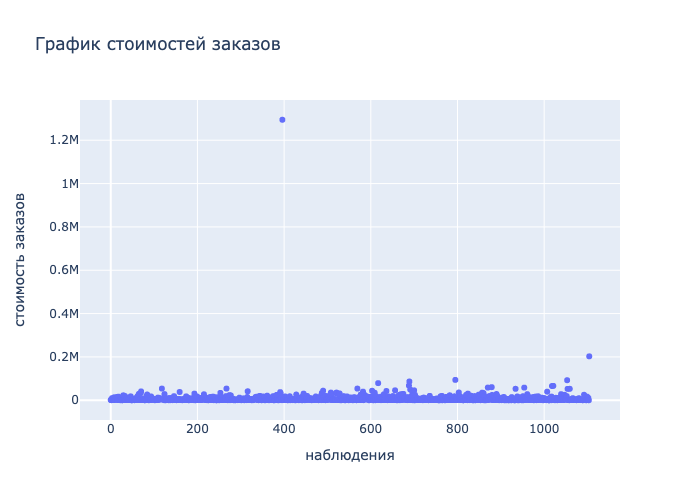

In [79]:
x_values = pd.Series(range(0, len(orders['revenue'])))

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x_values,
    y=orders['revenue'],
    mode='markers'))

fig.update_layout(title="График стоимостей заказов",
                  xaxis_title="наблюдения",
                  yaxis_title="стоимость заказов")
fig.show(renderer="png")

Видим один яркий аномальный выброс.

#### Выводы и предположения

В основном все заказы не выше 100 тыс. Есть аномальный заказ за 1.3 млн, и еще один выбивающийся не так явно - 202 тыс.

### 95-й и 99-й перцентили стоимости заказов

Посчитаем 95-й и 99-й перцентили стоимости заказов. 

In [60]:
print(np.percentile(orders['revenue'],[95,99]))

[27470.   58047.36]


Не более чем у 5% заказов чек дороже 27470 руб., а также не больше 1% заказов дороже 58047 руб.

#### Выводы и предположения

Выберем границу для определения аномальных заказов: исходя из подсчетов и графика выберем границу в 58 тыс.

### Статистическая значимость различий в конверсии между группами по «сырым» данным

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

* Сформулируем нулевую гипотезу: между конверсиями групп A и B нет разницы.
* Тогда обратная гипотеза будет следующей: в конверсиях групп есть статистически значимые различия.

Создадим переменные ordersByUsersA и ordersByUsersB, где для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов. Для этого подготовим дданные - сначла по пользователям:

In [61]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

Затем по заказам:

In [62]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

Соберем общую таблицу data со всеми посчитанными данными:

In [63]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули. Объявим переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули. 

In [64]:
sampleA = pd.concat(
    [ordersByUsersA['orders'],
     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() 
                                  - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat(
    [ordersByUsersB['orders'],
     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() 
                                  - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Посчитаем статистическую значимость различия конверсии по результатам двух недель теста, используя тест Манна-Уитни.

In [65]:
print("p-value для сравнения конверсии между группами: {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))

print("относительное различие в конверсии между группами: {0:.3f}".format((
    data['ordersPerDateB'].sum()
    /data['visitorsPerDateB'].sum())
    /(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

p-value для сравнения конверсии между группами: 0.53386
относительное различие в конверсии между группами: -0.026


#### Выводы и предположения

p-value гораздо больше, чем 0.05, поэтому нулевую гипотезу не можем отвергнуть - т. о. анализ "сырых данных" говорит о том, что в конверсии между группами нет статистически значимых различий.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

* Сформулируем нулевую гипотезу: между средними чеками групп A и B по "сырым" данным нет разницы.
* Тогда обратная гипотеза будет следующей: в среднем чеке групп по "сырым" данным есть статистически значимые различия.

In [66]:
print(
    "p-value для сравнения средних чеков между группами: {0:.3f}".format(
        stats.mannwhitneyu(
            orders[orders['group'] == 'A']['revenue'],
            orders[orders['group'] == 'B']['revenue'],
            alternative='two-sided'
        )[1]
    )
)

print(
    "относительный прирост среднего чека группы B: {0:.3f}".format(
        orders[orders['group'] == 'B']['revenue'].mean()
        / orders[orders['group'] == 'A']['revenue'].mean() - 1
    )
)

p-value для сравнения средних чеков между группами: 0.844
относительный прирост среднего чека группы B: 0.261


#### Выводы и предположения

p-value намного больше 0.05 - значит, значимых отличий в среднем чеке между группами нет.

Тем не менее относительное различие среднего чека между сегментами равно почти 26%.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

* Сформулируем нулевую гипотезу: между конверсиями групп A и B по "очищенным" данным нет разницы.
* Тогда обратная гипотеза будет следующей: в конверсии между группами по "очищенным" данным есть статистически значимые различия.

Подготовим очищенные от аномалий данные:

In [67]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['userId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 58000]['visitorId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
len(abnormalUsers)

17

Всего 17 пользователей с аномальными заказами!

In [68]:
orders['visitorId'].nunique()

1031

Создадим переменные sampleAFiltered и sampleBFiltered, в которых сохраним очищенные данные о заказах.

In [69]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


Посчитаем статистическую значимость различия конверсии после удаления аномальных пользователей. 

In [70]:
print("p-value для сравнения конверсии между группами по очищенным данным: {0:.5f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative='two-sided')[1]))
print("относительный прирост конверсии очищенной группы B: {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value для сравнения конверсии между группами по очищенным данным: 0.36083
относительный прирост конверсии очищенной группы B: 0.034


#### Выводы и предположения

Как и в случае с сырыми данными, p-value значительно больше 0.05, а значит, статиистическая значимость не достигнута. Т. е. конверсии групп A и B не различаются.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [71]:
print(
    "p-value для сравнения среднего чека между группами по очищенным данным: {0:.3f}".format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            alternative='two-sided'
        )[1]
    )
)

print(
    "относительный прирост среднего чека очищенной группы B: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value для сравнения среднего чека между группами по очищенным данным: 0.841
относительный прирост среднего чека очищенной группы B: -0.030


#### Выводы и предположения

Как и в случае сырых данных p-value значительно больше 0.05 - значит, значимых отличий в среднем чеке даже по очищенным данным между группами нет.

### Решение по результатам теста

**Приоритизация гипотез**

* гипотеза "база клиентов" была на 3-м месте при приориитизации  ICE, но при приоритизации RICE с большим отрывом вырывается вперед. Так получилось из-за того, что именно данная гипотеза имеет высший балл по охвату (10)
* "блоки рекомендаций" - не было в тройке при приоритизации ICE, там эта гипотеза была на пятом месте; при RICE - на втором месте. Здесь это благодаря опять же охвату (8), а также благодаря достаточно высокой уверенности в гипотезе (7)
* "два новых канала" встречается в обеих приоритизациях, но в ICE она на втором месте, а в RICE - на третьем (небольшое значение охвата (3) при высоких остальных параметрах, участвующих в ICE)
* при приоритизации RICE третье место делят две гиптезы - "два новых канала" и "актуальные акции" 

**Анализ данных**

* Выручка увеличивается в течение всего теста.
* График кумулятивной группы A растет равномерно, тогда как график группы B в одной точке начинает резко расти - либо это всплески числа заказов, либо появление очень дорогих заказов в выборке.
* Похоже, что в группу B с 18 августа (воскресенье) пришли очень активные пользователи, которые сделали много заказов, что повлияло на средний чек.
* Конверсии обеих групп начали выравниваться, начиная с 10 августа.
* Наблюдаем прирост конверсии группы B в 5% относительно группы A с 10 августа, но затем в районе 22 августа конверсия группы B пошла на спад относительно группы B.
* Не более 5% пользователей сделали больше одного заказа. И не более 1% - больше 3-х заказов.
* В основном все заказы не выше 100 тыс. Есть аномальный заказ за 1.3 млн, и еще один выбивающийся не так явно - 202 тыс.
* Не более чем у 5% заказов чек дороже 27470 руб., а также не больше 1% заказов дороже 58047 руб.

**А/Б-тест**

* Анализ "сырых данных" говорит о том, что в конверсии между группами нет статистически значимых различий.
* Значимых отличий в среднем чеке между группами нет.
* Как и в случае с сырыми данными, p-value значительно больше 0.05, а значит, статиистическая значимость не достигнута. Т. е. конверсии групп A и B не различаются.

В итоге статистически значимого различия по среднему чеку между группами нет, а также нет значимого различия мжеду группами по конверсии, даже при удалении аномальных значений. 

Поэтому делаем вывод, что нужно остановить тест ввиду отсутствия различий между группами.